In [1]:
import pandas as pd
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import glob


def aggregate_csv_features(data, chunk_size=1000):
    num_rows = len(data)
    aggregated_data = []

    for i in range(0, num_rows, chunk_size):
        chunk = data.iloc[i : i + chunk_size]

        # Count the number of packets with SYN and FIN flags
        syn_count = chunk[chunk["SYN Flag Cnt"] == 1].shape[0]
        fin_count = chunk[chunk["FIN Flag Cnt"] == 1].shape[0]
        print(f"Số gói tin có cờ SYN: {syn_count}")
        print(f"Số gói tin có cờ FIN: {fin_count}")

        # Count the number of TCP packets
        tcp_count = chunk[chunk["Protocol"] == 6].shape[0]
        print(f"Số gói tin TCP: {tcp_count}")

        # Calculate SYN and FIN per TCP ratio, avoid division by zero
        SYN_per_TCP = syn_count / tcp_count if tcp_count > 0 else 0
        FIN_per_TCP = fin_count / tcp_count if tcp_count > 0 else 0

        # Sum of backward and forward packets
        totbwd = chunk["Tot Bwd Pkts"].sum()
        totfwd = chunk["Tot Fwd Pkts"].sum()

        # Calculate backward packets per forward packets ratio, avoid division by zero
        bwk_per_fwk = totbwd / totfwd if totfwd > 0 else 0
        print(f"Backward per forward packet ratio: {bwk_per_fwk}")

        # Count ARP operations
        arp_1 = chunk[chunk["arp_operation"] == 1].shape[0]
        arp_2 = chunk[chunk["arp_operation"] == 2].shape[0]
        print(f"Số gói tin gửi đi: {arp_1}")
        print(f"Số gói tin phản hồi: {arp_2}")

        # Calculate ARP response rate, avoid division by zero
        rate_arp = arp_2 / arp_1 if arp_1 > 0 else 0
        print(rate_arp)

        # Average number of IP addresses mapped to a MAC address
        mac_addresses = chunk[chunk["arp_operation"] == 2]["sender_mac"].nunique()
        ip_addresses = chunk[chunk["arp_operation"] == 2]["sender_ip"].nunique()

        # Avoid division by zero
        avg_ip_per_mac = ip_addresses / mac_addresses if mac_addresses > 0 else 0
        print(f"Unique MAC addresses: {mac_addresses}")
        print(f"Unique IP addresses: {ip_addresses}")
        print(f"Average IPs per MAC: {avg_ip_per_mac}")

        aggregated_features = []

        for feature in data.columns:
            if feature not in [
                "Source IP",
                "Destination IP",
                "Label",
                "Protocol",
                "arp_operation",
                "protocol_type",
                "sender_mac",
                "sender_ip",
                "target_mac",
                "target_ip",
            ]:
                # Convert to numeric and coerce errors to NaN
                numeric_values = pd.to_numeric(chunk[feature], errors="coerce")
                mean_value = (
                    np.nanmean(numeric_values) if len(numeric_values) > 0 else 0
                )
                std_value = np.nanstd(numeric_values) if len(numeric_values) > 0 else 0
                skew_value = (
                    0 if len(numeric_values) < 3 else pd.Series(numeric_values).skew()
                )
                kurtosis_value = (
                    0
                    if len(numeric_values) < 4
                    else pd.Series(numeric_values).kurtosis()
                )
                median_value = (
                    np.nanmedian(numeric_values) if len(numeric_values) > 0 else 0
                )

                aggregated_features.extend(
                    [mean_value, std_value, skew_value, kurtosis_value, median_value]
                )

        aggregated_features.extend(
            [SYN_per_TCP, FIN_per_TCP, bwk_per_fwk, rate_arp, avg_ip_per_mac]
        )
        aggregated_data.append(aggregated_features)

    aggregated_df = pd.DataFrame(aggregated_data)
    return aggregated_df

In [ ]:
import glob
import pandas as pd

# Find all the CSV files
data= pd.read_csv("Raw_data/arp\ARP_Spoofing_test\ARP_Spoofing_00000_20230907021110.csv")
# In số thứ tự và tên cột
for idx, col in enumerate(data.columns):
    print(f"{idx}: {col}")


0: Unnamed: 0
1: Flow ID
2: Src IP
3: Src Port
4: Dst IP
5: Dst Port
6: Protocol
7: Timestamp
8: Flow Duration
9: Tot Fwd Pkts
10: Tot Bwd Pkts
11: TotLen Fwd Pkts
12: TotLen Bwd Pkts
13: Fwd Pkt Len Max
14: Fwd Pkt Len Min
15: Fwd Pkt Len Mean
16: Fwd Pkt Len Std
17: Bwd Pkt Len Max
18: Bwd Pkt Len Min
19: Bwd Pkt Len Mean
20: Bwd Pkt Len Std
21: Flow Byts/s
22: Flow Pkts/s
23: Flow IAT Mean
24: Flow IAT Std
25: Flow IAT Max
26: Flow IAT Min
27: Fwd IAT Tot
28: Fwd IAT Mean
29: Fwd IAT Std
30: Fwd IAT Max
31: Fwd IAT Min
32: Bwd IAT Tot
33: Bwd IAT Mean
34: Bwd IAT Std
35: Bwd IAT Max
36: Bwd IAT Min
37: Fwd PSH Flags
38: Bwd PSH Flags
39: Fwd URG Flags
40: Bwd URG Flags
41: Fwd Header Len
42: Bwd Header Len
43: Fwd Pkts/s
44: Bwd Pkts/s
45: Pkt Len Min
46: Pkt Len Max
47: Pkt Len Mean
48: Pkt Len Std
49: Pkt Len Var
50: FIN Flag Cnt
51: SYN Flag Cnt
52: RST Flag Cnt
53: PSH Flag Cnt
54: ACK Flag Cnt
55: URG Flag Cnt
56: CWE Flag Count
57: ECE Flag Cnt
58: Down/Up Ratio
59: Pkt Size A

#### Calculate features

In [ ]:
import glob
import pandas as pd

files = glob.glob("New_Data/MQTT/MQTT_Public_Flood.csv")

dataframes = []

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)
print(data)
data = data.drop(columns=["Label"])
data["Label"] = 2

In [ ]:
data.to_csv("New_Data/MQTT/MQTT_Public_Flood.csv")

In [ ]:
import glob
import pandas as pd

files = glob.glob("New_Data/*/*.csv")

dataframes = []

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,Label,Unnamed: 0,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,4.000000e+01,2.338090e+01,0.000000,-1.200000,40.0,1.020451e+07,1.355923e+07,0.756490,-1.295476,1039679.0,...,0.0,0.073171,0.220418,1.307692,2.500000,1,NaN,NaN,NaN,NaN
1,4.000000e+01,2.338090e+01,0.000000,-1.200000,40.0,1.279369e+07,1.488497e+07,0.423278,-1.733622,201145.0,...,0.0,0.046512,3.971916,1.250000,3.666667,1,NaN,NaN,NaN,NaN
2,7.300000e+01,4.243426e+01,0.000000,-1.200000,73.0,1.438033e+07,2.329432e+07,1.276194,-0.147985,203972.0,...,0.0,0.138462,0.340397,1.304348,3.200000,1,NaN,NaN,NaN,NaN
3,7.850000e+01,4.560976e+01,0.000000,-1.200000,78.5,2.035776e+07,3.558562e+07,1.332106,-0.082454,1489.5,...,0.0,0.150943,0.904077,1.272727,3.500000,1,NaN,NaN,NaN,NaN
4,4.995000e+02,2.886750e+02,0.000000,-1.200000,499.5,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.041667,2.000000,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183150,3.241629e+06,1.559556e+07,5.183135,25.600658,209144.5,2.269000e+00,1.037500e+01,13.325532,220.876719,1.0,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
183151,3.467766e+06,1.201458e+07,6.319188,46.499431,209755.0,2.840336e+00,7.184230e+00,8.512550,81.887051,1.0,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
183152,2.343212e+06,1.167541e+07,5.987188,37.113230,205582.5,1.844000e+00,6.272931e+00,11.037299,134.355900,1.0,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
183153,1.090835e+07,2.932026e+07,2.819238,6.549983,207143.0,4.500000e+00,1.376249e+01,9.670422,110.745014,1.0,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
#  Fill NaN values with 0 
data.fillna(0, inplace=True)
data.fillna(0, inplace=True)

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,Label,Unnamed: 0,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,40.0,23.380904,0.0,-1.2,40.0,1.020451e+07,1.355923e+07,0.756490,-1.295476,1039679.0,...,0.0,0.073171,0.220418,1.307692,2.500000,1,0.0,0.0,0.0,0.0
1,40.0,23.380904,0.0,-1.2,40.0,1.279369e+07,1.488497e+07,0.423278,-1.733622,201145.0,...,0.0,0.046512,3.971916,1.250000,3.666667,1,0.0,0.0,0.0,0.0
2,73.0,42.434263,0.0,-1.2,73.0,1.438033e+07,2.329432e+07,1.276194,-0.147985,203972.0,...,0.0,0.138462,0.340397,1.304348,3.200000,1,0.0,0.0,0.0,0.0
3,78.5,45.609758,0.0,-1.2,78.5,2.035776e+07,3.558562e+07,1.332106,-0.082454,1489.5,...,0.0,0.150943,0.904077,1.272727,3.500000,1,0.0,0.0,0.0,0.0
4,499.5,288.674990,0.0,-1.2,499.5,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.041667,2.000000,1,0.0,0.0,0.0,0.0


In [ ]:

X = data.drop(columns=["Label"])
y = data["Label"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

new_data = X_scaled_df.copy()
new_data["Label"] = y.values

In [ ]:
new_data

,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,Unnamed: 0,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Label
0,3.900883e-07,4.324641e-07,0.405991,0.004828,3.333360e-07,1.949446e-01,2.420850e-01,0.511961,0.004676,1.703327e-02,...,0.0,0.073171,0.004951,0.653846,0.357143,0.0,0.0,0.0,0.0,1
1,3.900883e-07,4.324641e-07,0.405991,0.004828,3.333360e-07,2.444077e-01,2.657545e-01,0.506693,0.004241,3.295399e-03,...,0.0,0.046512,0.089213,0.625000,0.523810,0.0,0.0,0.0,0.0,1
2,7.119112e-07,7.848839e-07,0.405991,0.004828,6.083383e-07,2.747186e-01,4.158942e-01,0.520178,0.005817,3.341714e-03,...,0.0,0.138462,0.007646,0.652174,0.457143,0.0,0.0,0.0,0.0,1
3,7.655483e-07,8.436193e-07,0.405991,0.004828,6.541720e-07,3.889100e-01,6.353417e-01,0.521062,0.005882,2.440278e-05,...,0.0,0.150943,0.020306,0.636364,0.500000,0.0,0.0,0.0,0.0,1
4,4.871228e-06,5.339467e-06,0.405991,0.004828,4.162534e-06,0.000000e+00,0.000000e+00,0.500000,0.005964,0.000000e+00,...,0.0,0.000000,0.000000,0.020833,0.285714,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183150,3.161303e-02,2.884627e-01,0.504219,0.031784,1.742885e-03,4.334645e-08,1.852341e-07,0.710695,0.225524,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1
183151,3.381838e-02,2.222273e-01,0.525749,0.052803,1.747972e-03,5.426113e-08,1.282664e-07,0.634595,0.087363,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1
183152,2.285149e-02,2.159538e-01,0.519457,0.043363,1.713201e-03,3.522735e-08,1.119962e-07,0.674515,0.139519,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1
183153,1.063805e-01,5.423212e-01,0.459420,0.012623,1.726206e-03,8.596697e-08,2.457140e-07,0.652903,0.116049,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1


In [ ]:
columns_to_drop = [col for col in new_data.columns if new_data[col].nunique() == 1]

data_cleaned = new_data.drop(columns=columns_to_drop)
print(f"Các cột đã bị loại bỏ: {columns_to_drop}")

Các cột đã bị loại bỏ: ['159', '160', '161', '162', '163', '164', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359']


In [ ]:
data_cleaned

,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,Unnamed: 0,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Label
0,3.900883e-07,4.324641e-07,0.405991,0.004828,3.333360e-07,1.949446e-01,2.420850e-01,0.511961,0.004676,1.703327e-02,...,0.0,0.073171,0.004951,0.653846,0.357143,0.0,0.0,0.0,0.0,1
1,3.900883e-07,4.324641e-07,0.405991,0.004828,3.333360e-07,2.444077e-01,2.657545e-01,0.506693,0.004241,3.295399e-03,...,0.0,0.046512,0.089213,0.625000,0.523810,0.0,0.0,0.0,0.0,1
2,7.119112e-07,7.848839e-07,0.405991,0.004828,6.083383e-07,2.747186e-01,4.158942e-01,0.520178,0.005817,3.341714e-03,...,0.0,0.138462,0.007646,0.652174,0.457143,0.0,0.0,0.0,0.0,1
3,7.655483e-07,8.436193e-07,0.405991,0.004828,6.541720e-07,3.889100e-01,6.353417e-01,0.521062,0.005882,2.440278e-05,...,0.0,0.150943,0.020306,0.636364,0.500000,0.0,0.0,0.0,0.0,1
4,4.871228e-06,5.339467e-06,0.405991,0.004828,4.162534e-06,0.000000e+00,0.000000e+00,0.500000,0.005964,0.000000e+00,...,0.0,0.000000,0.000000,0.020833,0.285714,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183150,3.161303e-02,2.884627e-01,0.504219,0.031784,1.742885e-03,4.334645e-08,1.852341e-07,0.710695,0.225524,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1
183151,3.381838e-02,2.222273e-01,0.525749,0.052803,1.747972e-03,5.426113e-08,1.282664e-07,0.634595,0.087363,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1
183152,2.285149e-02,2.159538e-01,0.519457,0.043363,1.713201e-03,3.522735e-08,1.119962e-07,0.674515,0.139519,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1
183153,1.063805e-01,5.423212e-01,0.459420,0.012623,1.726206e-03,8.596697e-08,2.457140e-07,0.652903,0.116049,1.638320e-08,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1


In [ ]:
data_cleaned = data_cleaned.drop(columns=["Unnamed: 0", "Unnamed: 0.1",  "Unnamed: 0.2", "Unnamed: 0.3"])

In [ ]:
data_cleaned = data_cleaned.drop(columns=["399", "398", "397", "396", "395"])

In [ ]:
data_cleaned["Label"].value_counts()

Label
1    94037
2    84319
3     3524
0     1275
Name: count, dtype: int64

In [ ]:
data_cleaned.loc[data_cleaned["Label"] == 2, "Label"] = 1
data_cleaned.loc[data_cleaned["Label"] == 3, "Label"] = 1

In [ ]:
data_cleaned["Label"].value_counts()

Label
1    181880
0      1275
Name: count, dtype: int64

In [ ]:
data_cleaned.to_csv("data.csv")

In [ ]:
# Filter out rows where Label is 3
filtered_data = data_cleaned[(data_cleaned["Label"] != 2)]

# Set Label values of 2 to 1
filtered_data.loc[filtered_data["Label"] == 3, "Label"] = 1
# Save the filtered and modified data to a CSV file
filtered_data.to_csv("Session2/set1.csv", index=False)

In [ ]:

set2 = pd.read_csv("Session2/set1.csv")
print(set2)

In [ ]:
# Filter out rows where Label is 3
filtered_data = data_cleaned[(data_cleaned["Label"] == 2)]

# Set Label values of 2 to 1
filtered_data.loc[filtered_data["Label"] == 2, "Label"] = 1
# Save the filtered and modified data to a CSV file
filtered_data.to_csv("Session2/set2.csv", index=False)

In [ ]:
set2

,0,1,2,3,4,5,6,7,8,9,...,386,387,388,389,390,391,392,393,394,Label
0,0.000754,0.000381,0.373322,0.006035,0.000759,3.176320e-05,7.066912e-06,0.473972,0.005964,3.096425e-05,...,0.000000,0.574298,0.000000,0.0,0.0,0.000000,0.027711,0.013857,0.000000,1
1,0.000848,0.000342,0.373204,0.006035,0.000830,3.157216e-05,1.097951e-05,0.474306,0.005964,3.270087e-05,...,0.000000,0.574298,0.000000,0.0,0.0,0.000000,0.027725,0.013857,0.000000,1
2,0.000892,0.000019,0.381283,0.006035,0.000766,1.281226e-05,1.671931e-05,0.527384,0.005964,2.129816e-07,...,0.000000,0.574298,0.000000,0.0,0.0,0.000000,0.031179,0.013857,0.000000,1
3,0.000754,0.000010,0.434679,0.006035,0.000642,3.183962e-05,1.120520e-06,0.526218,0.005964,2.670462e-05,...,0.000000,0.574298,0.000000,0.0,0.0,0.000000,0.027705,0.013857,0.000000,1
4,0.000754,0.000011,0.427295,0.006035,0.000643,3.183962e-05,3.619053e-07,0.480817,0.005964,2.742548e-05,...,0.000000,0.574298,0.000000,0.0,0.0,0.000000,0.027705,0.013857,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84314,0.000000,0.000000,0.405991,0.006035,0.000000,0.000000e+00,0.000000e+00,0.500000,0.005964,0.000000e+00,...,0.007242,0.000000,1.000000,1.0,0.0,0.000000,0.027705,0.013871,0.016667,1
84315,0.000000,0.000000,0.405991,0.006035,0.000000,0.000000e+00,0.000000e+00,0.500000,0.005964,0.000000e+00,...,0.000000,0.574298,0.000000,1.0,0.0,0.000000,0.027705,0.013936,0.016667,1
84316,0.033887,0.240276,0.474915,0.017732,0.000000,1.288003e-07,2.504634e-06,0.897468,0.635433,0.000000e+00,...,0.231336,0.526486,0.004947,1.0,0.0,0.001646,0.028070,0.013857,0.000000,1
84317,0.000000,0.000000,0.405991,0.006035,0.000000,0.000000e+00,0.000000e+00,0.500000,0.005964,0.000000e+00,...,0.020410,0.373396,0.120616,1.0,0.0,0.000000,0.027705,0.013980,0.025758,1


In [ ]:
set2.to_csv("Session1/set2.csv", index= False)

In [ ]:

filtered_data = set2 [(["Label"] == 3)]
filtered_data.to_csv("Session1/set2.csv", index=False)

In [ ]:
# Filter out rows where Label is 3
filtered_data = data_cleaned[
    (data_cleaned["Label"] != 2) & (data_cleaned["Label"] != 3)
]

# Set Label values of 2 to 1
filtered_data.loc[filtered_data["Label"] == 2, "Label"] = 1
filtered_data.loc[filtered_data["Label"] == 3, "Label"] = 1
# Save the filtered and modified data to a CSV file
filtered_data.to_csv("Session3/set1.csv", index=False)

In [ ]:
set1 = pd.read_csv("Session3/set1.csv")

In [ ]:
set1["Label"].value_counts()

In [ ]:
# Filter out rows where 'Label' is equal to 2 or 3
filtered_data = data_cleaned[
    (data_cleaned["Label"] == 2) | (data_cleaned["Label"] == 3)
]

# Modify the 'Label' column and set it to 1
filtered_data.loc[:, "Label"] = 1

# Save the filtered data to a CSV file
filtered_data.to_csv("Session3/set2.csv", index=False)

In [ ]:
set2 = pd.read_csv("Session3/set2.csv")

In [ ]:
set2["Label"].value_counts()

In [ ]:
import glob
import pandas as pd

files = glob.glob("Session2/*.csv")

dataframes = []

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

In [ ]:
data

In [ ]:
columns_to_drop = [col for col in data.columns if data[col].nunique() == 1]

data_cleaned = data.drop(columns=columns_to_drop)
print(f"Các cột đã bị loại bỏ: {columns_to_drop}")


In [ ]:
data["Label"].value_counts()

In [ ]:
data.to_csv("data.csv")

#### Trích xuất label = 0

In [ ]:
import pandas as pd
data = pd.read_csv("New_binary_label_data_cleaned.csv")

In [ ]:
data = data.drop(columns=["395","396","397","398","399"])

In [ ]:
data.shape

In [ ]:
data.to_csv("359_features.csv")

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
label_counts = data["Label"].value_counts()

# Plotting the value counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind="bar")

# Adding titles and labels
plt.title("Counts of Unique Labels in 'Label' Column")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(axis="y")  # Add a horizontal grid

# Display the plot
plt.show()

In [ ]:
print(len(data.columns))

In [ ]:
columns_to_drop = [col for col in data.columns if data[col].nunique() == 1]

data_cleaned = data.drop(columns=columns_to_drop)
print(f"Các cột đã bị loại bỏ: {columns_to_drop}")

data_cleaned.to_csv("New_binary_label_data_cleaned.csv", index=False)

In [ ]:
import glob
import pandas as pd

files_arp = glob.glob("New_Data/ARP/*.csv")
files_benign = glob.glob("New_Data/BENIGN/*.csv")
file_ddos = glob.glob("New_Data/DDOS/*/*.csv")
file_dos = glob.glob("New_Data/DOS/*/*.csv")
file_mqtt= glob.glob("New_Data/MQTT/*/*.csv")
file_recon = glob.glob("New_Data/RECON/*/*.csv")
dataframes = []

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

In [ ]:
import glob
import pandas as pd

# Define file patterns
files_arp = glob.glob("New_Data/ARP/*.csv")
files_benign = glob.glob("New_Data/BENIGN/*.csv")
file_ddos = glob.glob("New_Data/DDOS/*.csv")
file_dos = glob.glob("New_Data/DOS/*.csv")
file_mqtt = glob.glob("New_Data/MQTT/*.csv")
file_recon = glob.glob("New_Data/RECON/*.csv")

# Combine all files into one list
all_files = files_arp + files_benign + file_ddos + file_dos + file_mqtt + file_recon

# List to store file names and sample counts
file_sample_counts = []

# Iterate over all files and count the number of samples
for file in all_files:
    try:
        df = pd.read_csv(file)
        sample_count = len(df)
        file_sample_counts.append({"File": file, "Sample Count": sample_count})
    except Exception as e:
        file_sample_counts.append({"File": file, "Sample Count": f"Error: {e}"})

# Create a DataFrame from the list
df_sample_counts = pd.DataFrame(file_sample_counts)

# Display the DataFrame
print(df_sample_counts)


In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Define file patterns
files_arp = glob.glob("New_Data/ARP/*.csv")
files_benign = glob.glob("New_Data/BENIGN/*.csv")
file_ddos = glob.glob("New_Data/DDOS/*.csv")
file_dos = glob.glob("New_Data/DOS/*.csv")
file_mqtt = glob.glob("New_Data/MQTT/*.csv")
file_recon = glob.glob("New_Data/RECON/*.csv")


# Function to count samples in files
def count_samples(files):
    total_samples = 0
    for file in files:
        try:
            df = pd.read_csv(file)
            total_samples += len(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    return total_samples


# Count samples for each category
count_arp = count_samples(files_arp)
count_benign = count_samples(files_benign)
count_ddos = count_samples(file_ddos)
count_dos = count_samples(file_dos)
count_mqtt = count_samples(file_mqtt)
count_recon = count_samples(file_recon)

# Create a DataFrame to display the results
data = {
    "Category": ["Benign", "ARP", "DDOS", "DOS", "MQTT", "RECON"],
    "Number of Samples": [
        count_benign,
        count_arp,
        count_ddos,
        count_dos,
        count_mqtt,
        count_recon,
    ],
}

df_summary = pd.DataFrame(data)

# Display the DataFrame
print(df_summary)

SystemError: <built-in function isinstance> returned a result with an exception set

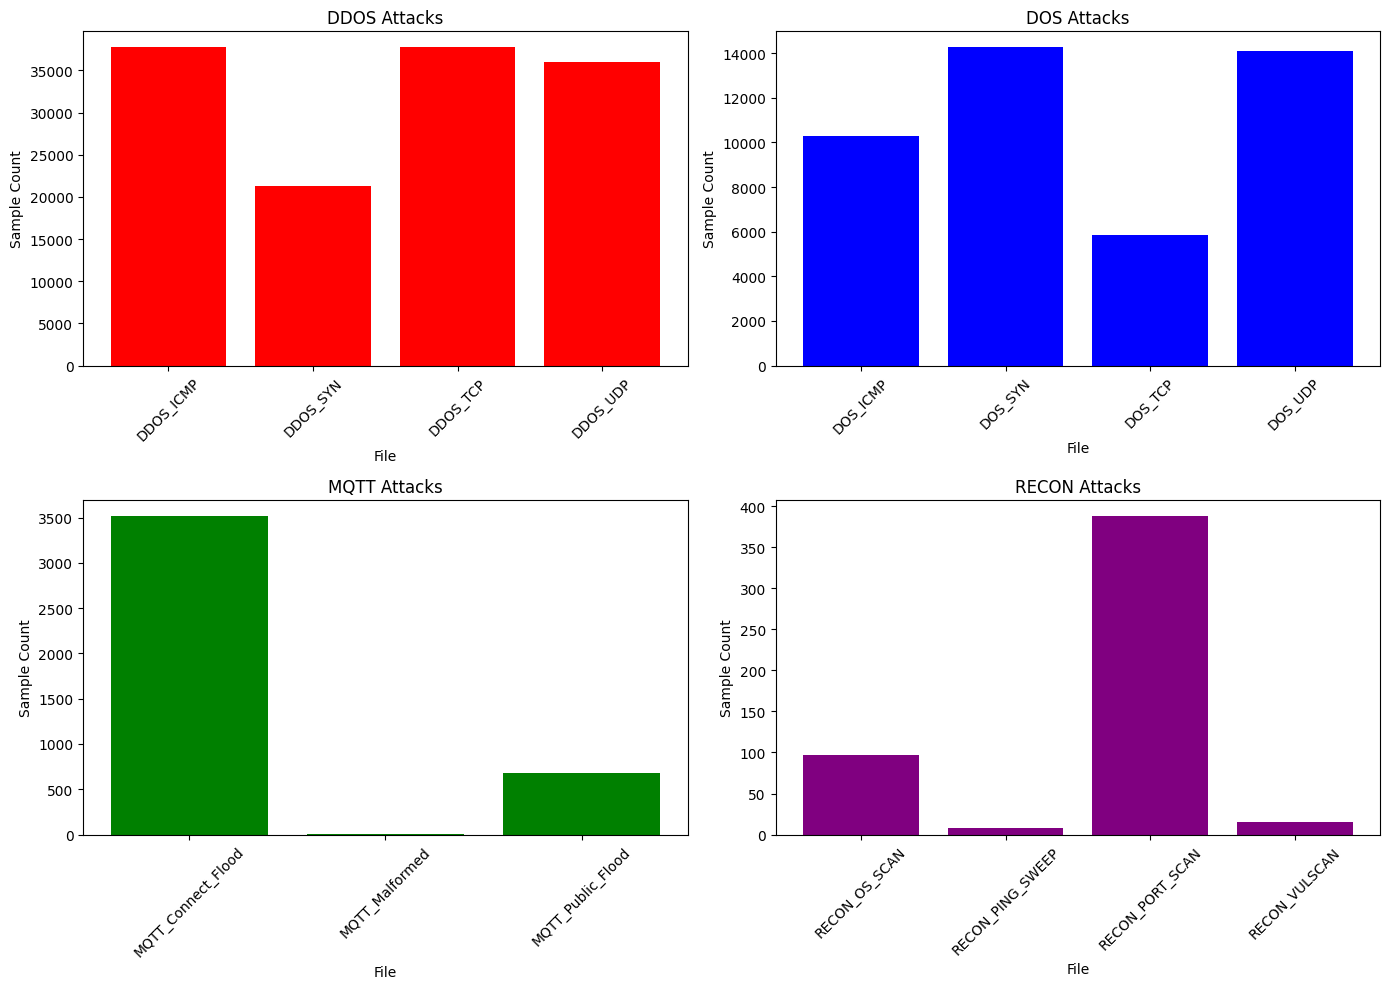

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for plotting
data = {
    "File": [
        "DDOS_ICMP",
        "DDOS_SYN",
        "DDOS_TCP",
        "DDOS_UDP",
        "DOS_ICMP",
        "DOS_SYN",
        "DOS_TCP",
        "DOS_UDP",
        "MQTT_Connect_Flood",
        "MQTT_Malformed",
        "MQTT_Public_Flood",
        "RECON_OS_SCAN",
        "RECON_PING_SWEEP",
        "RECON_PORT_SCAN",
        "RECON_VULSCAN",
    ],
    "Sample Count": [
        37735,
        21249,
        37735,
        35945,
        10292,
        14260,
        5830,
        14086,
        3516,
        8,
        678,
        97,
        8,
        388,
        15,
    ],
}

df = pd.DataFrame(data)

# Define categories explicitly to avoid overlap
ddos_files = df["File"].str.contains("DDOS")
dos_files = df["File"].str.contains("DOS") & ~df["File"].str.contains("DDOS")
mqtt_files = df["File"].str.contains("MQTT")
recon_files = df["File"].str.contains("RECON")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot DDOS
axs[0, 0].bar(df[ddos_files]["File"], df[ddos_files]["Sample Count"], color="red")
axs[0, 0].set_title("DDOS Attacks")
axs[0, 0].set_xlabel("File")
axs[0, 0].set_ylabel("Sample Count")
axs[0, 0].tick_params(axis="x", rotation=45)

# Plot DOS
axs[0, 1].bar(df[dos_files]["File"], df[dos_files]["Sample Count"], color="blue")
axs[0, 1].set_title("DOS Attacks")
axs[0, 1].set_xlabel("File")
axs[0, 1].set_ylabel("Sample Count")
axs[0, 1].tick_params(axis="x", rotation=45)

# Plot MQTT
axs[1, 0].bar(df[mqtt_files]["File"], df[mqtt_files]["Sample Count"], color="green")
axs[1, 0].set_title("MQTT Attacks")
axs[1, 0].set_xlabel("File")
axs[1, 0].set_ylabel("Sample Count")
axs[1, 0].tick_params(axis="x", rotation=45)

# Plot RECON
axs[1, 1].bar(df[recon_files]["File"], df[recon_files]["Sample Count"], color="purple")
axs[1, 1].set_title("RECON Attacks")
axs[1, 1].set_xlabel("File")
axs[1, 1].set_ylabel("Sample Count")
axs[1, 1].tick_params(axis="x", rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()